# Encoder Decoder LSTM for Quantile Regression

https://arxiv.org/pdf/2106.01271.pdf

In [1]:
from models.DAX import DAX_quantile_regression, DAX_baseline
from models.energy import energy_quantile_regression
from functions import get_energy, get_DAX, merge_submissions, check_submission
from functions.prepare_data import split_time
from functions.evaluation import evaluate_horizon
from tqdm import tqdm
from functions import evaluate_dax
from functions import naive_ensemble
import pandas as pd
#import minmaxscaler
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, date, timedelta
import tensorflow.keras.backend as K



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming energydata is loaded from a function 'get_energy.get()'
energydata = get_energy.get()

# Creating a DataFrame
df = pd.DataFrame(energydata)

# Display the first few rows of the DataFrame
print(df.head())

# Ensure 'date_time' is the DataFrame index for extracting temporal features
if 'date_time' in df.columns:
    df.set_index('date_time', inplace=True)

# Extracting temporal features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['week'] = df.index.weekday  # Weekday as a feature

# Add other temporal features if relevant

# Splitting the data into train and test sets chronologically
train_size = int(len(df) * 0.8)
train_df, test_df = df[:train_size], df[train_size:]

# Selecting the features and target for training
feature_columns = ['hour', 'day', 'month', 'week']  # Add other columns if needed
train_X = train_df[feature_columns].values
train_y = train_df['gesamt'].values.reshape(-1, 1)
test_X = test_df[feature_columns].values
test_y = test_df['gesamt'].values.reshape(-1, 1)

# Shapes of the training and testing data
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# Reshaping input data for LSTM [samples, time steps, features]
train_X_lstm = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X_lstm = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

# Feature Scaling
scaler = StandardScaler()

# Reshape for scaling and then scale
train_X_lstm_scaled = scaler.fit_transform(train_X_lstm.reshape(train_X_lstm.shape[0], -1))
train_X_lstm_scaled = train_X_lstm_scaled.reshape(train_X_lstm.shape)

# Prepare and scale the test data
test_X_lstm_scaled = scaler.transform(test_X_lstm.reshape(test_X_lstm.shape[0], -1))
test_X_lstm_scaled = test_X_lstm_scaled.reshape(-1, 1, train_X_lstm.shape[2])

# Target Scaling
scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(train_y)

# Assuming test_y is also needed for performance evaluation
test_y_scaled = scaler_y.transform(test_y)

# Now, train_X_lstm_scaled, train_y_scaled, test_X_lstm_scaled, and test_y_scaled are ready for model training


  0%|          | 0/263 [00:00<?, ?it/s]/Users/stephantimpe/PycharmProjects/probabilistic-forecasting-challenge/functions/get_energy.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 263/263 [00:26<00:00,  9.97it/s]


                       gesamt  weekday
date_time                             
2018-12-24 00:00:00  42.02925        0
2018-12-24 01:00:00  39.61025        0
2018-12-24 02:00:00  39.13875        0
2018-12-24 03:00:00  39.42100        0
2018-12-24 04:00:00  40.74775        0
(35321, 4) (35321, 1) (8831, 4) (8831, 1)


In [32]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

# Define the input sequence
input_seq = Input(shape=(train_X_lstm_scaled.shape[1], train_X_lstm_scaled.shape[2]))
print("Input shape:", input_seq.shape)
# Encoder LSTM
encoder_out, state_h, state_c = LSTM(100, return_state=True)(input_seq)
print("Encoder output shape:", encoder_out.shape)
print("State H shape:", state_h.shape)
print("State C shape:", state_c.shape)
encoder_states = [state_h, state_c]


Input shape: (None, 1, 4)
Encoder output shape: (None, 100)
State H shape: (None, 100)
State C shape: (None, 100)


2024-01-06 17:02:47.523564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-06 17:02:47.524856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-06 17:02:47.525694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Decoder

In [33]:
from keras.layers import Dense, TimeDistributed

# Set the number of time steps to predict
decoder_steps = train_X_lstm_scaled.shape[1]

# Decoder LSTM
decoder_lstm = LSTM(100, return_sequences=True)
decoder_out = decoder_lstm(RepeatVector(decoder_steps)(encoder_out), initial_state=encoder_states)

# Output layer
decoder_dense = TimeDistributed(Dense(5))  # Change 5 to the number of quantiles
decoder_outputs = decoder_dense(decoder_out)

# Define the model
model = Model(inputs=input_seq, outputs=decoder_outputs)


2024-01-06 17:02:48.459356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-06 17:02:48.459746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-06 17:02:48.460369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Quantile Loss Function

In [73]:
def quantile_loss(quantiles, y_true, y_pred):
    e = y_true - y_pred
    losses = []
    for q in quantiles:
        loss = K.maximum(q * (e), (q - 1) * (e))
        losses.append(K.mean(loss, axis=-1))
    return K.mean(K.stack(losses, axis=-1), axis=-1)



Compile

In [74]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
model.compile(optimizer='adam', loss=lambda y_true, y_pred: quantile_loss(quantiles, y_true, y_pred))


Train

In [75]:
history = model.fit(train_X_lstm_scaled, train_y_scaled, epochs=10, batch_size=72, 
                    validation_data=(test_X_lstm_scaled, test_y_scaled), verbose=2, shuffle=False)

Epoch 1/10


2024-01-06 17:06:28.342299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-06 17:06:28.343116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-06 17:06:28.345045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

491/491 - 4s - loss: 2.1889 - val_loss: 2.0732 - 4s/epoch - 8ms/step
Epoch 2/10
491/491 - 3s - loss: 1.6974 - val_loss: 1.7099 - 3s/epoch - 6ms/step
Epoch 3/10
491/491 - 2s - loss: 1.4181 - val_loss: 1.5549 - 2s/epoch - 4ms/step
Epoch 4/10
491/491 - 2s - loss: 1.2212 - val_loss: 1.3602 - 2s/epoch - 4ms/step
Epoch 5/10
491/491 - 2s - loss: 1.0476 - val_loss: 1.1672 - 2s/epoch - 4ms/step
Epoch 6/10
491/491 - 2s - loss: 0.8925 - val_loss: 1.0061 - 2s/epoch - 4ms/step
Epoch 7/10
491/491 - 2s - loss: 0.7529 - val_loss: 0.8586 - 2s/epoch - 4ms/step
Epoch 8/10
491/491 - 2s - loss: 0.6330 - val_loss: 0.7297 - 2s/epoch - 4ms/step
Epoch 9/10
491/491 - 2s - loss: 0.5452 - val_loss: 0.6287 - 2s/epoch - 4ms/step
Epoch 10/10
491/491 - 2s - loss: 0.4883 - val_loss: 0.5585 - 2s/epoch - 4ms/step


In [76]:
test_mse = model.evaluate(test_X_lstm_scaled, test_y_scaled, verbose=0)
print(f"Test MSE: {test_mse}")

Test MSE: 0.5550987720489502


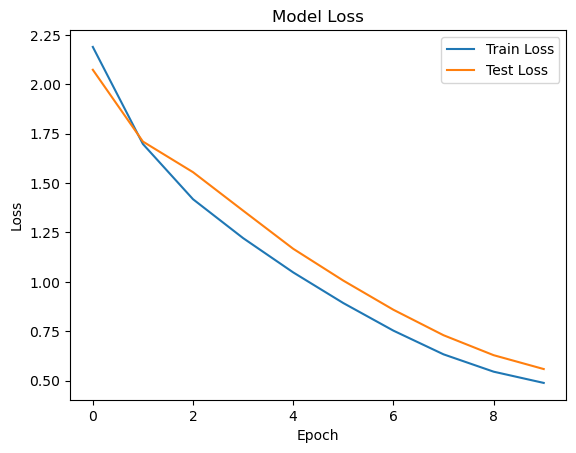

In [77]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [78]:
predictions = model.predict(test_X_lstm_scaled)


  1/276 [..............................] - ETA: 1:11

2024-01-06 17:06:51.064828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-06 17:06:51.065491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-06 17:06:51.065982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

276/276 [==============================] - 0s 657us/step


In [79]:
predictions

array([[[1.3633893 , 1.377544  , 1.3793373 , 1.3473651 , 1.3414671 ]],

       [[0.63763547, 0.6493862 , 0.6493964 , 0.63159376, 0.62136114]],

       [[0.25007853, 0.25793806, 0.2589992 , 0.24660087, 0.239488  ]],

       ...,

       [[0.7453604 , 0.7481214 , 0.74663854, 0.7471286 , 0.74899113]],

       [[0.7491951 , 0.7519913 , 0.7505104 , 0.7509152 , 0.7527611 ]],

       [[0.77030367, 0.7732966 , 0.7718232 , 0.7717642 , 0.7735113 ]]],
      dtype=float32)

In [80]:
from datetime import datetime, timedelta

def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0:  # Target day already happened this week
        days_ahead += 7
    return d + timedelta(days_ahead)

# Define your horizons in hours
horizons = [36, 40, 44, 60, 64, 68]

# Calculate the next Thursday at 00:00
now = datetime.now()
next_thursday = next_weekday(now, 3)  # 3 represents Thursday
next_thursday = next_thursday.replace(hour=0, minute=0, second=0, microsecond=0)

# Calculate future timestamps
future_timestamps = [next_thursday + timedelta(hours=h) for h in horizons]


In [81]:


# Assuming feature_columns, future_timestamps, df, and scaler are already defined

# Function to extract features for a given timestamp
def extract_features_for_timestamp(timestamp, df):
    features = {
        'hour': timestamp.hour,
        'day': timestamp.day,
        'month': timestamp.month,
        'week': timestamp.weekday()
    }
    # If other features are needed, add them here

    # Convert to format similar to your training data
    feature_vector = [features[col] for col in feature_columns]
    return feature_vector

prediction_inputs = [extract_features_for_timestamp(ts, df) for ts in future_timestamps]

# Reshape for LSTM
prediction_inputs = np.array(prediction_inputs).reshape(-1, 1, len(feature_columns))

# Scale the prediction inputs
prediction_inputs_scaled = scaler.transform(prediction_inputs.reshape(prediction_inputs.shape[0], -1))
prediction_inputs_scaled = prediction_inputs_scaled.reshape(-1, 1, len(feature_columns))


In [82]:
# Get predictions
predictions = model.predict(prediction_inputs_scaled)

# Reshape predictions from 3D to 2D
predictions_reshaped = predictions.reshape(predictions.shape[0], -1)

# Inverse transform predictions
original_scale_predictions = scaler_y.inverse_transform(predictions_reshaped)


1/1 [==============================] - 0s 10ms/step


In [83]:
# Create DataFrame with the reshaped predictions
df_predictions = pd.DataFrame()


columns = [f'q{q}' for q in quantiles]
df_predictions[columns] = original_scale_predictions


In [84]:
# Static values DataFrame
df_static = pd.DataFrame({
    'forecast_date': [next_thursday.strftime('%Y-%m-%d')] * len(original_scale_predictions),
    'target': ['energy'] * len(original_scale_predictions),
    'horizon': [f'{h} hour' for h in horizons for _ in range(len(original_scale_predictions)//len(horizons))]
})

# Concatenate static DataFrame with predictions DataFrame
final_df = pd.concat([df_static, df_predictions], axis=1)


In [85]:
final_df

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-11,energy,36 hour,63.419792,63.446789,63.432266,63.437160,63.455421
1,2024-01-11,energy,40 hour,61.478649,61.507191,61.519924,61.444939,61.472725
2,2024-01-11,energy,44 hour,55.914742,55.931438,55.979366,55.851913,55.878250
3,2024-01-11,energy,60 hour,63.419483,63.446480,63.431953,63.436859,63.455116
4,2024-01-11,energy,64 hour,60.198826,60.212891,60.223343,60.186504,60.222034
5,2024-01-11,energy,68 hour,54.471546,54.476097,54.524151,54.420040,54.455246


In [86]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed
import tensorflow.keras.backend as K
from functions import get_energy

def energy_forecast(input_data=None, forecast_date=None):
    # Load default energy data if none provided
    if input_data is None:
        energydata = get_energy.get()
        df = pd.DataFrame(energydata)
    else:
        df = pd.DataFrame(input_data)

    # Default forecast date is the current date
    if forecast_date is None:
        forecast_date = datetime.now()
    else:
        forecast_date = pd.to_datetime(forecast_date)

    # Data preprocessing
    if 'date_time' in df.columns:
        df.set_index('date_time', inplace=True)

    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['week'] = df.index.weekday

    train_size = int(len(df) * 0.8)
    train_df, test_df = df[:train_size], df[train_size:]

    feature_columns = ['hour', 'day', 'month', 'week']
    train_X = train_df[feature_columns].values
    train_y = train_df['gesamt'].values.reshape(-1, 1)
    test_X = test_df[feature_columns].values
    test_y = test_df['gesamt'].values.reshape(-1, 1)

    train_X_lstm = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X_lstm = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

    scaler = StandardScaler()
    train_X_lstm_scaled = scaler.fit_transform(train_X_lstm.reshape(train_X_lstm.shape[0], -1))
    train_X_lstm_scaled = train_X_lstm_scaled.reshape(train_X_lstm.shape)
    test_X_lstm_scaled = scaler.transform(test_X_lstm.reshape(test_X_lstm.shape[0], -1))
    test_X_lstm_scaled = test_X_lstm_scaled.reshape(-1, 1, train_X_lstm.shape[2])

    scaler_y = StandardScaler()
    train_y_scaled = scaler_y.fit_transform(train_y)
    test_y_scaled = scaler_y.transform(test_y)

    # Model building
    input_seq = Input(shape=(train_X_lstm_scaled.shape[1], train_X_lstm_scaled.shape[2]))
    encoder_out, state_h, state_c = LSTM(100, return_state=True)(input_seq)
    encoder_states = [state_h, state_c]

    decoder_steps = train_X_lstm_scaled.shape[1]
    decoder_lstm = LSTM(100, return_sequences=True)
    decoder_out = decoder_lstm(RepeatVector(decoder_steps)(encoder_out), initial_state=encoder_states)
    decoder_dense = TimeDistributed(Dense(5))  # Change 5 to the number of quantiles
    decoder_outputs = decoder_dense(decoder_out)
    model = Model(inputs=input_seq, outputs=decoder_outputs)

    # Quantile Loss Function
    def quantile_loss(quantiles, y_true, y_pred):
        e = y_true - y_pred
        losses = []
        for q in quantiles:
            loss = K.maximum(q * e, (q - 1) * e)
            losses.append(K.mean(loss, axis=-1))
        return K.mean(K.stack(losses, axis=-1), axis=-1)

    quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
    model.compile(optimizer='adam', loss=lambda y_true, y_pred: quantile_loss(quantiles, y_true, y_pred))

    # Model training
    history = model.fit(train_X_lstm_scaled, train_y_scaled, epochs=10, batch_size=72,
                        validation_data=(test_X_lstm_scaled, test_y_scaled), verbose=2, shuffle=False)

    # Prediction preparation
    horizons = [36, 40, 44, 60, 64, 68]
    future_timestamps = [forecast_date + timedelta(hours=h) for h in horizons]

    def extract_features_for_timestamp(timestamp, df):
        features = {
            'hour': timestamp.hour,
            'day': timestamp.day,
            'month': timestamp.month,
            'week': timestamp.weekday()
        }
        feature_vector = [features[col] for col in feature_columns]
        return feature_vector

    prediction_inputs = [extract_features_for_timestamp(ts, df) for ts in future_timestamps]
    prediction_inputs = np.array(prediction_inputs).reshape(-1, 1, len(feature_columns))
    prediction_inputs_scaled = scaler.transform(prediction_inputs.reshape(prediction_inputs.shape[0], -1))
    prediction_inputs_scaled = prediction_inputs_scaled.reshape(-1, 1, len(feature_columns))

    # Generate predictions
    predictions = model.predict(prediction_inputs_scaled)
    predictions_reshaped = predictions.reshape(predictions.shape[0], -1)
    original_scale_predictions = scaler_y.inverse_transform(predictions_reshaped)

    # Format predictions
    df_predictions = pd.DataFrame()
    columns = [f'q{q}' for q in quantiles]
    df_predictions[columns] = original_scale_predictions
    df_static = pd.DataFrame({
        'forecast_date': [forecast_date.strftime('%Y-%m-%d')] * len(original_scale_predictions),
        'target': ['energy'] * len(original_scale_predictions),
        'horizon': [f'{h} hour' for h in horizons for _ in range(len(original_scale_predictions)//len(horizons))]
    })
    final_df = pd.concat([df_static, df_predictions], axis=1)

    return final_df

# Example usage
result = energy_forecast()
print(result.head())


  0%|          | 0/263 [00:00<?, ?it/s]/Users/stephantimpe/PycharmProjects/probabilistic-forecasting-challenge/functions/get_energy.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 263/263 [00:29<00:00,  8.98it/s]
2024-01-06 17:27:46.311330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-06 17:27:46.318318: I tensorflow/cor

Epoch 1/10


2024-01-06 17:27:46.792879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-06 17:27:46.794080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-06 17:27:46.795432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

491/491 - 6s - loss: 0.4198 - val_loss: 0.3981 - 6s/epoch - 12ms/step
Epoch 2/10
491/491 - 3s - loss: 0.4122 - val_loss: 0.3922 - 3s/epoch - 6ms/step
Epoch 3/10
491/491 - 3s - loss: 0.4047 - val_loss: 0.3962 - 3s/epoch - 6ms/step
Epoch 4/10
491/491 - 3s - loss: 0.4005 - val_loss: 0.3937 - 3s/epoch - 7ms/step
Epoch 5/10
491/491 - 3s - loss: 0.3975 - val_loss: 0.3928 - 3s/epoch - 6ms/step
Epoch 6/10
491/491 - 3s - loss: 0.3957 - val_loss: 0.3918 - 3s/epoch - 6ms/step
Epoch 7/10
491/491 - 3s - loss: 0.3944 - val_loss: 0.3903 - 3s/epoch - 6ms/step
Epoch 8/10
491/491 - 3s - loss: 0.3936 - val_loss: 0.3890 - 3s/epoch - 6ms/step
Epoch 9/10
491/491 - 3s - loss: 0.3928 - val_loss: 0.3877 - 3s/epoch - 6ms/step
Epoch 10/10
491/491 - 3s - loss: 0.3921 - val_loss: 0.3862 - 3s/epoch - 6ms/step


2024-01-06 17:28:19.631790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-06 17:28:19.632715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-06 17:28:19.633485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 406ms/step
  forecast_date  target  horizon     q0.025      q0.25       q0.5      q0.75  \
0    2024-01-06  energy  36 hour  60.794369  61.151493  60.892384  61.334419   
1    2024-01-06  energy  40 hour  60.838432  61.201675  60.920498  61.367596   
2    2024-01-06  energy  44 hour  60.890728  61.261539  60.957245  61.410194   
3    2024-01-06  energy  60 hour  66.420174  66.279999  66.077187  66.891205   
4    2024-01-06  energy  64 hour  66.482437  66.343872  66.127502  66.945755   

      q0.975  
0  60.912144  
1  60.927525  
2  60.951942  
3  66.317802  
4  66.355034  


In [88]:
result

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-06,energy,36 hour,60.794369,61.151493,60.892384,61.334419,60.912144
1,2024-01-06,energy,40 hour,60.838432,61.201675,60.920498,61.367596,60.927525
2,2024-01-06,energy,44 hour,60.890728,61.261539,60.957245,61.410194,60.951942
3,2024-01-06,energy,60 hour,66.420174,66.279999,66.077187,66.891205,66.317802
4,2024-01-06,energy,64 hour,66.482437,66.343872,66.127502,66.945755,66.355034
5,2024-01-06,energy,68 hour,66.550781,66.414665,66.184082,67.006668,66.398575
